In [1]:
%load_ext tikzmagic

---
slug: "/blog/logisticregression"
date: "2021-03-15"
title: "Logistic Regression"
category: "Machine Learning"
order: 2
---

### Introduction

Logistic regression is a parametric classification method that is used to estimate binary class output given real-valued input vectors. 
In this post, cross entropy loss is used as the loss function and gradient descent (or batched gradient descent) is used to learn parameters.


The computation graph below shows how logistic regression works. 
The dot product of each input, a vector $\vec{x}$ of size $D$, and weight vector $\vec{w}$ transposed is taken, resulting in $z$.
$z$ is put through the sigmoid function, and the loss is calculated using the mean squared error on label $y$ and $\sigma(z)$.

The bias term $\beta$ is ignored for the purposes of this post, but can easily be appended to weight vector $\vec{w}$ after appending a $1$ to an input vector $\vec{x}$.

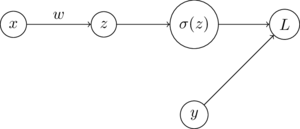

In [2]:
%%tikz -s 300,300 -sc=2
\node[draw, circle] (x) at (0, 1) {$x$};
\node[draw, circle] (z) at (1, 1) {$z$};
\node[draw, circle] (s) at (2, 1) {$\sigma(z)$};
\node[draw, circle] (y) at (2, 0) {$y$};
\node[draw, circle] (l) at (3, 1) {$L$};
\draw[->] (x) edge node[midway, above] {$w$} (z);
\draw[->] (z) -- (s);
\draw[->] (s) -- (l);
\draw[->] (y) -- (l);

### Learning

Given a data set $X$ of size $N$ with $D$ dimensions, parameters $w$ must be learned that minimize our loss function $L_{CE}(y, \hat{y})$.
The weight vector is learned using gradient descent.
The derivation for term $\frac{\partial L}{\partial w}$ in the weight update is displayed in the derivations section of this post.

$$
\begin{aligned}
    \sigma(z) &= \frac{1}{1 + e^{-z}} & \text{[Logistic function]}\\
    L_{\text{CE}}(y, \hat{y}) &= -\left[ y\log \hat{y} + (1-y)\log(1-\hat{y}) \right]& \text{[Cross entropy loss]}\\
    w_i &= w_i - \alpha \frac{\partial L}{\partial w_i} & \text{[Weight update]}\\
    &= w_i - \alpha \left[x_i (\sigma(z) - y)\right] &\\
    w_i &= w_i - \alpha \frac{1}{B}\sum^B_{j=1}x_{j,i}(\sigma(z)-y) & \text{[Batch weight update]}\\
\end{aligned}
$$

### Code

Code for a logistic regression classifier is shown in the block below

In [3]:
from typing import List
from tqdm import trange
import torch


def ErrorRate(y: torch.Tensor, yhat: torch.Tensor) -> float:
    """ Calculate error rate (1 - accuracy)

    Args:
        y: true labels
        yhat: predicted labels

    Returns:
        error rate
    """

    return torch.sum((y != yhat).float()) / y.shape[0]


class LogisticRegressionClassifier:

    def __init__(self) -> None:
        """ Instantiate logistic regression classifier
        """

        self.w = None
        self.calcError = ErrorRate


    def fit(self, x, y, alpha=1e-4, epochs=1000, batch=32) -> None:
        """ Fit logistic regression classifier to dataset

        Args:
            x: input data
            y: input labels
            alpha: alpha parameter for weight update
            epochs: number of epochs to train
            batch: size of batches for training
        """

        self.w = torch.rand((1, x.shape[1]))

        epochs = trange(epochs, desc='Error')
        for epoch in epochs:

            start, end = 0, batch
            for b in range((x.shape[0]//batch)+1):
                hx = self.probs(x[start:end])
                dw = self.calcGradient(x[start:end], y[start:end], hx)
                self.w = self.w - (alpha * dw)
                start += batch
                end += batch

            hx = self.predict(x)
            error = self.calcError(y, hx)
            epochs.set_description('Err: %.4f' % error)


    def probs(self, x: torch.Tensor) -> torch.Tensor:
        """ Determine probability of label being 1

        Args:
            x: input data

        Returns:
            probability for each member of input
        """

        hx = 1 / (1 + torch.exp(-torch.einsum('ij,kj->i', x, self.w)))[:, None]
        return hx


    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """ Predict labels

        Args:
            x: input data

        Returns:
            labels for each member of input
        """

        hx = self.probs(x)
        hx = (hx >= 0.5).float()
        return hx


    def calcGradient(self, x: torch.Tensor, y: torch.Tensor, hx: torch.Tensor) -> torch.Tensor:
        """ Calculate weight gradient

        Args:
            x: input data
            y: input labels
            hx: predicted probabilities

        Returns:
            tensor of gradient values the same size as weights
        """

        return torch.sum(x * (hx - y), dim=0) / x.shape[0]

### Derivations

Derivative of loss function $L$ with respect to sigmoid output $a=\sigma(z)$:

$$
\begin{aligned}
    \frac{\partial L}{\partial a} &= \frac{\partial}{\partial a} - \left[y\log a + (1-y) \log (1-a)\right]\\
    &= - \left[
        y\frac{\partial}{\partial a}\log a +
        (1-y)\frac{\partial}{\partial a}\log (1-a)
    \right]\\
    &= - \left[
        \frac{y}{a}\frac{\partial}{\partial a}a +
        \frac{(1-y)}{(1-a)}\frac{\partial}{\partial a}(1-a)
    \right]\\
    &= -\left[\frac{y}{a} - \frac{(1-y)}{(1-a)}\right]
\end{aligned}
$$

Derivative of sigmoid function $\sigma(z)$ with respect to sigmoid input $z$:

$$
\begin{aligned}
    \frac{\partial \sigma(z)}{\partial z} &= \frac{\partial}{\partial z}\frac{1}{1 + e^{-z}}\\
    &= \frac{\partial}{\partial z}(1 + e^{-z})^{-1}\\
    &= -(1 + e^{-z})^{-2}\frac{\partial}{\partial z}(1 + e^{-z})\\
    &= -(1 + e^{-z})^{-2}\frac{\partial}{\partial z}(e^{-z})\\
    &= \frac{-e^{-z}}{(1 + e^{-z})^{2}}\frac{\partial}{\partial z}(-z)\\
    &= \frac{e^{-z}}{(1 + e^{-z})^{2}}\\
    &= \frac{e^{-z}}{1 + e^{-z}} \frac{1}{1 + e^{-z}}\\
    &= \left(
        \frac{1 + e^{-z}}{1 + e^{-z}} -
        \frac{1}{1 + e^{-z}} 
    \right)\frac{1}{(1 + e^{-z})}\\
    &= (1 - \sigma(z))\sigma(z)\\
\end{aligned}
$$

Derivative of linear combination $z$ with respect to weight $w_i$:

$$
\begin{aligned}
    \frac{\partial z}{\partial w_i} &= \frac{\partial}{\partial w_i} \sum^D_{j=1}w_j \times x_j\\
    &= x_i
\end{aligned}
$$

Derivative of loss function $L$ with respect to weight $w_i$:

$$
\begin{aligned}
    \frac{\partial L}{\partial w_i} &= 
    \frac{\partial z}{\partial w_i}
    \frac{\partial \sigma(z)}{\partial z}
    \frac{\partial L}{\partial \sigma(z)}\\ 
    &= x_i \left[(1-\sigma(z))\sigma(z)\right]\left[\frac{1-y}{1-\sigma(z)}-\frac{y}{\sigma(z)}\right]\\
    &= x_i [(1-y)\sigma(z) - (1-\sigma(z))y] \\
    &= x_i [\sigma(z)-y\sigma(z) - y + y\sigma(z)] \\
    &= x_i [\sigma(z)- y] \\
\end{aligned}
$$

### Resources
- Jurafsky, Daniel, and James H. Martin. Speech and Language Processing: An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition. Pearson, 2020.
- Russell, Stuart J., et al. Artificial Intelligence: A Modern Approach. 3rd ed, Prentice Hall, 2010.